In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
from sympy import Symbol, exp, pi, Poly, fraction, Add, Mul, latex, Pow  # noqa
from functools import reduce
from IPython.display import Math, display
import sympy as sy

import re


def replace_latex_powers(latex_str):
    return re.sub(r"\\left\(z\^\{-1\}\\right\)\^\{(\d+)\}", r"z^{-\1}", latex_str)


def evalf_poly(expr, var):
    return reduce(
        lambda x, y: Add(x, y, evaluate=True),
        [
            c.evalf() * var**ix
            for ix, c in enumerate(reversed(expr.as_poly(var).all_coeffs()))
        ],
    )


def poly_coeffs(expr, var):
    return expr.as_poly(var).all_coeffs()


from audio_utils import DEFAULT_SAMPLE_RATE


class Resonator:
    def __init__(self, f_k, tau, A, f_s=DEFAULT_SAMPLE_RATE):
        self.f_k = Symbol("f_k")
        self.f_s = Symbol("f_s")
        self.tau = Symbol("tau")
        self.A = Symbol("A")
        self.z_inv = Symbol("z^-1")

        self.values = {self.f_k: f_k, self.f_s: f_s, self.tau: tau, self.A: A}
        self.p_k = exp(2j * pi * f_k / f_s) * exp(-1 / (tau * f_s))
        self.a_2_k = abs(self.p_k) ** 2
        self.a_1_k = -2 * sy.re(self.p_k)
        self.b_k = A / f_s * sy.im(self.p_k)
        self.H_res_numerator = self.b_k * self.z_inv
        self.H_res_denominator = (
            1 + self.a_1_k * self.z_inv + self.a_2_k * self.z_inv**2
        )

        # self.verify_resonator()

    def verify_resonator(self):
        # check for stability
        if not self.check_stability():
            raise RuntimeError("The resonator is not stable")
        if (
            not (self.estimate_resonant_frequency() - self.f_k.subs(self.values))
            / self.f_k.subs(self.values)
            < 0.01
        ):
            raise RuntimeError(
                "The resonator is not resonating at the desired frequency"
            )

    def transfer_function(self):
        return Mul(
            (self.H_res_numerator),
            Pow((self.H_res_denominator), -1, evaluate=True),
            evaluate=False,
        )

    def evalf_transfer_function(self):
        return evalf_poly(self.H_res_numerator, self.z_inv), evalf_poly(
            self.H_res_denominator, self.z_inv
        )

    def latex_transfer_function(self):
        return replace_latex_powers(latex(self.transfer_function()))

    def display_transfer_function(self):
        evalf_num = evalf_poly(self.H_res_numerator.subs(self.values), self.z_inv)
        evalf_denom = evalf_poly(self.H_res_denominator.subs(self.values), self.z_inv)

        print("transfer function:")
        display(
            Math(
                r"H_\text{res} = "
                + replace_latex_powers(
                    latex(
                        Mul(
                            (evalf_num),
                            Pow((evalf_denom), -1, evaluate=True),
                            evaluate=False,
                        )
                    )
                )
            )
        )

    @property
    def b(self):
        return self.b_k.subs(self.values)

    def get_b_and_a(self):
        import numpy as np

        b = np.array(poly_coeffs(self.H_res_numerator, self.z_inv)[::-1]).astype(
            np.float64
        )
        a = np.array(poly_coeffs(self.H_res_denominator, self.z_inv)[::-1]).astype(
            np.float64
        )

        return b, a

    def estimate_resonant_frequency(self):
        import numpy as np
        from scipy.signal import freqz

        w, h = freqz(b, a, worN=16384)
        # find the frequency with the maximum amplitude
        max_freq = w[np.argmax(abs(h))]

        # normalize the frequency to the range [0, f_s/2] from [0, pi]
        return max_freq * self.f_s.subs(self.values) / (2 * np.pi)

    def check_stability(self):
        import numpy as np
        from scipy.signal import tf2zpk

        b, a = self.get_b_and_a()
        zeros, poles, _ = tf2zpk(b, a)
        return np.all(np.abs(poles) < 1)


r = Resonator(f_k=440 * 4, tau=0.2, A=10.0)
r.display_transfer_function()
b, a = r.get_b_and_a()
r.estimate_resonant_frequency()


transfer function:


<IPython.core.display.Math object>

1760.33935546875

/Users/briancruz/repos/research/music_299_2025sp/.venv/lib/python3.12/site-packages/cffi/vengine_cpy.py:192: UserWarning: reimporting '_cffi__x7069f79bx69c269b5' might overwrite older definitions
  warnings.warn("reimporting %r might overwrite older definitions"
Exception ignored from callback for ffi.gc <cdata 'mydsp *' 0x11531c910>:
Traceback (most recent call last):
  File "/var/folders/zk/5c2c39w140d2jm1q_p1lzdr00000gn/T/ipykernel_68793/4216171223.py", line 15, in <module>
TypeError: initializer for ctype 'mydsp *' appears indeed to be 'mydsp *', but the types are different (check that you are not e.g. mixing up different ffi instances)


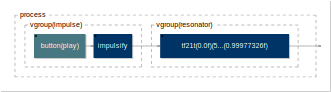

(1, 50000)


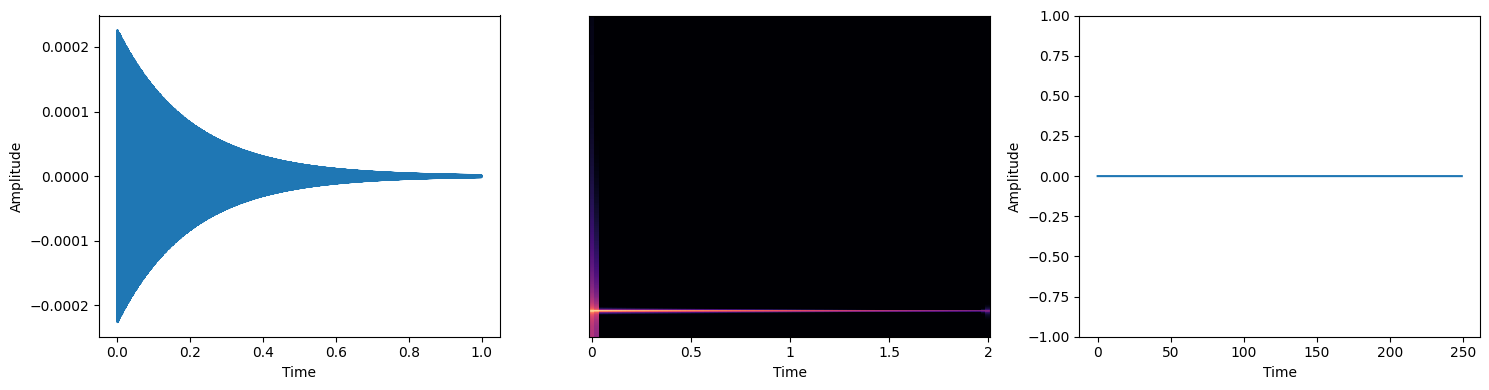

In [36]:
from pyfaust import FaustProcessor

code = f"""
import("stdfaust.lib");

b0 = {b[0]};
b1 = {b[1]};
b2 = 0.0;
a1 = {a[1]};
a2 = {a[2]};

process = vgroup("impulse", (button("play"): ba.impulsify))
		: vgroup("resonator", fi.tf21t(b0,b1,b2,a1,a2));
"""
with FaustProcessor(code) as fp:
    fp.show_signal_graph()

    fp.dsp.dsp.b_impulse.p_play.zone = 1

    N_samples = 50000
    out = fp.compute(N_samples)
    out.play(normalize=True)


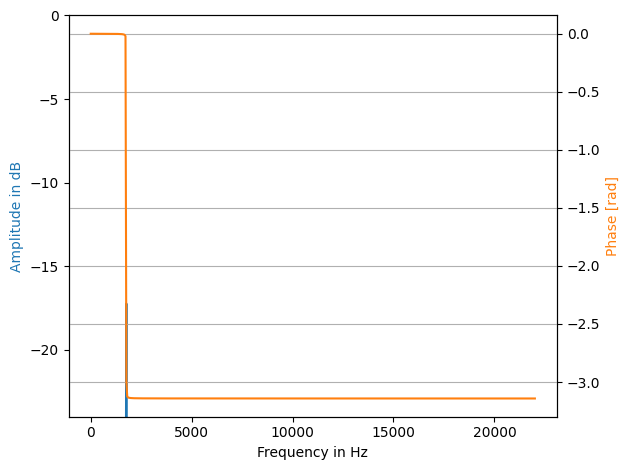

In [14]:
from audio_utils import plot_freqz

plot_freqz(b, a)